In [28]:
import pandas as pd

df_sayo = pd.read_csv("Sayopillow (2).csv")
df_smartwatch = pd.read_csv("unclean_smartwatch_health_data.csv")

In [29]:
# Rename columns in smartwatch data to match SaYoPillow
column_mapping = {
    "Heart Rate (BPM)": "hr",
    "Blood Oxygen Level (%)": "bo",
    "Sleep Duration (hours)": "sr.1",
    "Stress Level": "sl"
}
df_smartwatch.rename(columns=column_mapping, inplace=True)

In [30]:
# Keep only relevant columns
common_columns = list(set(df_sayo.columns) & set(df_smartwatch.columns))
df_smartwatch = df_smartwatch[common_columns]

In [31]:
# Convert "sl" to numeric, forcing errors='coerce' to handle non-numeric values
if "sl" in df_smartwatch.columns:
    df_smartwatch["sl"] = pd.to_numeric(df_smartwatch["sl"], errors='coerce')
    # Apply stress level conversion (1-10 → 0-4 scale)
    df_smartwatch["sl"] = ((df_smartwatch["sl"] - 1) * (4 / 9)).round().astype("Int64")

In [32]:
# Merge datasets (row-wise)
df_extended = pd.concat([df_sayo, df_smartwatch], ignore_index=True)

In [33]:
# Save the extended dataset
extended_path = "Extended_SaYoPillow (3).csv"
df_extended.to_csv(extended_path, index=False)

In [34]:
# Display sample
print(df_extended.head())

      sr      rr       t      lm      bo    rem     sh     hr  sl
0  93.80  25.680  91.840  16.600  89.840  99.60  1.840  74.20   3
1  91.64  25.104  91.552  15.880  89.552  98.88  1.552  72.76   3
2  60.00  20.000  96.000  10.000  95.000  85.00  7.000  60.00   1
3  85.76  23.536  90.768  13.920  88.768  96.92  0.768  68.84   3
4  48.12  17.248  97.872   6.496  96.248  72.48  8.248  53.12   0


In [35]:
df_extended.tail()

,sr,rr,t,lm,bo,rem,sh,hr,sl
10625,NaN,NaN,NaN,NaN,98.931927,NaN,NaN,78.819386,3
10626,NaN,NaN,NaN,NaN,95.773035,NaN,NaN,48.632659,0
10627,NaN,NaN,NaN,NaN,97.945874,NaN,NaN,73.834442,1
10628,NaN,NaN,NaN,NaN,98.401058,NaN,NaN,NaN,3
10629,NaN,NaN,NaN,NaN,98.475606,NaN,NaN,70.063864,2


In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.metrics import accuracy_score, classification_report


warnings.filterwarnings("ignore")

#  Step 1: Load Data (Replace df_extended with actual dataset)
df = df_extended.copy()

# #  Step 2: Convert all columns to numeric (force errors to NaN)
# df = df.apply(pd.to_numeric, errors='coerce')

# # Step 3: Impute Missing Values using Iterative Imputer
# imputer = IterativeImputer(max_iter=10, random_state=42)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# # Step 4: Remove duplicate rows
# df_imputed = df_imputed.drop_duplicates()

# #  Step 5: Ensure target variable has no NaN values
# df_imputed = df_imputed.dropna(subset=["sl"])  # Drop rows where target is NaN
# df_imputed["sl"] = df_imputed["sl"].astype(int)  # Convert target variable to integer

# #  Step 6: Split Features and Target Variable
# X = df_imputed.drop(columns=["sl"])
# y = df_imputed["sl"]

In [37]:
#  Step 2: Convert all columns to numeric (force errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

In [38]:
# Step 3: Impute Missing Values using Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [39]:
# Step 4: Remove duplicate rows
df_imputed = df_imputed.drop_duplicates()

In [40]:
#  Step 5: Ensure target variable has no NaN values
df_imputed = df_imputed.dropna(subset=["sl"])  # Drop rows where target is NaN
df_imputed["sl"] = df_imputed["sl"].astype(int)  # Convert target variable to integer

In [41]:
#  Step 6: Split Features and Target Variable
X = df_imputed.drop(columns=["sl"])
y = df_imputed["sl"]

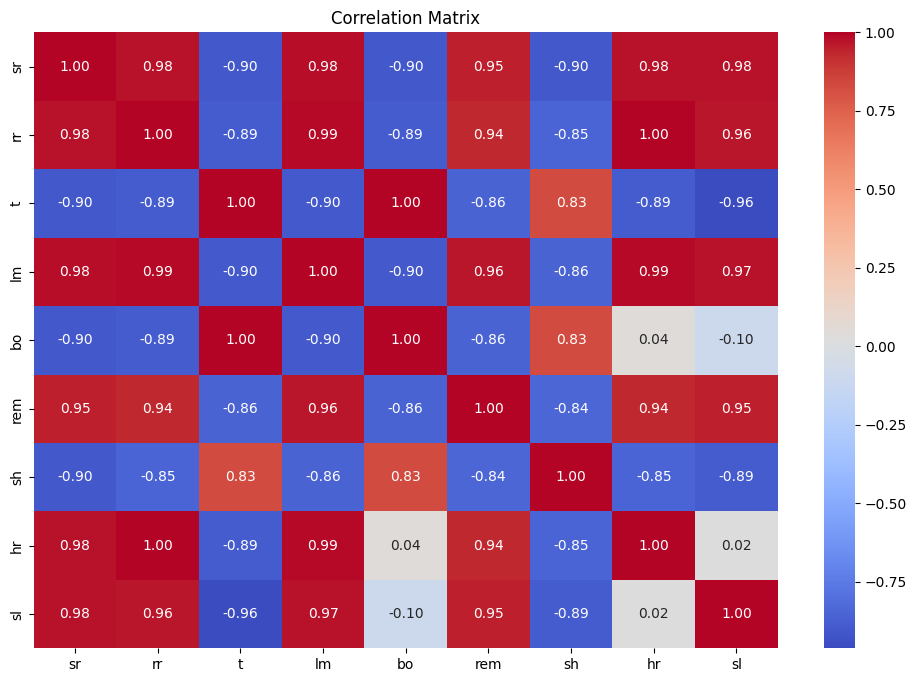

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Apply SMOTE for balancing classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [44]:
from sklearn.ensemble import RandomForestClassifier
# Model 1: Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest:")
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


 Random Forest:
0.979649787032655
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       0.99      0.91      0.95       461
           2       0.91      1.00      0.95       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.98      2113
   macro avg       0.98      0.98      0.98      2113
weighted avg       0.98      0.98      0.98      2113



In [45]:
from sklearn.naive_bayes import GaussianNB
# Model 2: Naïve Bayes
nb = GaussianNB()
nb.fit(X_train_smote, y_train_smote)
y_pred_nb = nb.predict(X_test)
print("\nNaïve Bayes:")
print(accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naïve Bayes:
0.950780880265026
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       420
           1       0.96      0.90      0.93       461
           2       0.87      0.98      0.92       415
           3       0.98      0.91      0.94       408
           4       0.97      0.99      0.98       409

    accuracy                           0.95      2113
   macro avg       0.95      0.95      0.95      2113
weighted avg       0.95      0.95      0.95      2113



In [46]:
from sklearn.linear_model import LogisticRegression
#  Model 3: Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test)
print("\n Logistic Regression:")
print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


 Logistic Regression:
0.9791765262659725
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      0.91      0.95       461
           2       0.91      1.00      0.95       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.98      2113
   macro avg       0.98      0.98      0.98      2113
weighted avg       0.98      0.98      0.98      2113



In [47]:
from sklearn.svm import SVC
# Model 4: Support Vector Machine (SVM)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_smote, y_train_smote)
y_pred_svm = svm.predict(X_test)
print("\n SVM:")
print(accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


 SVM:
0.9943208707998107
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       1.00      0.97      0.99       461
           2       0.97      1.00      0.99       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.99      2113
   macro avg       0.99      0.99      0.99      2113
weighted avg       0.99      0.99      0.99      2113



In [48]:
from sklearn.tree import DecisionTreeClassifier
# Model 5: Decision Tree
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train_smote, y_train_smote)
y_pred_dt = dt.predict(X_test)
print("\nDecision Tree:")
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



Decision Tree:
0.9739706578324657
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       420
           1       0.98      0.90      0.94       461
           2       0.90      0.99      0.94       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.97      2113
   macro avg       0.98      0.98      0.97      2113
weighted avg       0.98      0.97      0.97      2113



In [49]:
from xgboost import XGBClassifier
#  Model 6: XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)
print("\n XGBoost:")
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


 XGBoost:
0.9772834831992427
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       420
           1       0.98      0.92      0.95       461
           2       0.91      0.99      0.95       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.98      2113
   macro avg       0.98      0.98      0.98      2113
weighted avg       0.98      0.98      0.98      2113



In [50]:
import pickle
# Define the filename for the saved model
filename = 'svm_model.pkl'

# Open a file in write-binary mode and save the model
with open(filename, 'wb') as file:
    pickle.dump(svm, file)